In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *
from ipyexperiments import *
from fastai.basic_train import *

In [4]:
import sys
sys.path.append("../dev")
from data_utils import seed_everything
from fastai.train import *

In [5]:
#http://unixnme.blogspot.com/2018/07/pytorch-implementation-of-batchnorm.html
class AccumulateBatchNorm(nn.Module):
    def __init__(self, num_features, eps, momentum, running_mean=None, running_var=None,
                 weight=None, bias=None, name=None):
        super(AccumulateBatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.running_mean = torch.zeros(num_features) if running_mean is None else running_mean
        self.running_var = torch.zeros(num_features) if running_var is None else running_var
        self.weight = nn.Parameter(torch.randn(num_features, requires_grad=True))
        self.bias = nn.Parameter(torch.zeros(num_features, requires_grad=True))
        if weight is not None: self.weight.data.copy_(weight)
        if bias is not None: self.bias.data.copy_(bias)
        self.name = name
        self.reset_batch_stats()
        self._train()
    
    def reset_running_stats(self):
        self.running_mean = torch.zeros(self.num_features)
        self.running_var = torch.ones(self.num_features)
            
    def reset_batch_stats(self):
        "reset accumulated batch stats, at the end of full batch"
        self.batch_sum = 0.
        self.batch_n = 0.
        self.batch_sq_sum = 0.
        
    def update_running_stats(self):
        "updates running mean and var with current stats, at the end of full batch"
        with torch.no_grad():
            self.running_mean += (1 - self.momentum)*self.running_mean + self.momentum*self.batch_mean
            self.running_var += (1 - self.momentum)*self.running_var + self.momentum*self.batch_var
        
    def _train(self): self._training = True
    def _eval(self): self._training = False
        
    def _batchnorm(self, x, weight, bias, mean, var, eps):
        if len(x.shape) == 4:
            x = x - weight.reshape(1,weight.size(0),1,1).contiguous()
            x = x / (var.reshape(1,weight.size(0),1,1).contiguous() + eps)
            x = weight.reshape(1,weight.size(0),1,1).contiguous()*x + bias.reshape(1,weight.size(0),1,1).contiguous()
            return x
            
        if len(x.shape) == 2:
            x = x - mean
            x = x / (var + eps)
            x = weight*x + bias
            return x
    
    def forward(self, x):      
        "update input (a part of a batch) using batch stats calculated so far"  
        self.batch_sum += x.view(x.size(0), x.size(1), -1).mean(2).sum(0)*x.size(0)
        self.batch_sq_sum += x.view(x.size(0), x.size(1), -1).pow(2).mean(2).sum(0)
        self.batch_n += x.size(0)
        self.batch_mean = self.batch_sum / self.batch_n
        self.batch_var = self.batch_sq_sum / self.batch_n - (self.batch_sum / self.batch_n).pow(2)
        if self._training: x = self._batchnorm(x, self.weight, self.bias, self.batch_mean, self.batch_var, self.eps)
        else: x = self._batchnorm(x, self.weight, self.bias, self.running_mean, self.running_var, self.eps)
        return x
    
    def __repr__(self):
        return (f"AccumulateBatchNorm({self.num_features}) \n from {self.name}" if self.name else
                                        f"AccumulateBatchNorm({self.num_features})")

def convert_to_accbn(m):
    "convert a batchnorm module to accumulated batchnorm"
    num_features = m.num_features
    eps = m.eps
    momentum = m.momentum
    weight = m.weight.data
    bias = m.bias.data
    running_mean = m.running_mean.data
    running_var = m.running_var.data
    return AccumulateBatchNorm(num_features, eps, momentum, running_mean, running_var, weight, bias,
                               name=m.__repr__()).to(device=next(m.parameters()).device)

In [ ]:
class BatchNorm2d(nn.BatchNorm2d):
    def forward(self, x):
        self._check_input_dim(x)
        y = x.transpose(0,1)
        return_shape = y.shape
        y = y.contiguous().view(x.size(1), -1)
        mu = y.mean(dim=1)
        sigma2 = y.var(dim=1)
        if self.training is not True:
            y = y - self.running_mean.view(-1, 1)
            y = y / (self.running_var.view(-1, 1)**.5 + self.eps)
        else:
            if self.track_running_stats is True:
                with torch.no_grad():
                    self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*mu
                    self.running_var = (1-self.momentum)*self.running_var + self.momentum*sigma2
            y = y - mu.view(-1,1)
            y = y / (sigma2.view(-1,1)**.5 + self.eps)

        y = self.weight.view(-1, 1) * y + self.bias.view(-1, 1)
        return y.view(return_shape).transpose(0,1)

In [ ]:
#http://unixnme.blogspot.com/2018/07/pytorch-implementation-of-batchnorm.html
class AccumulateBatchNorm(nn.Module):
    def __init__(self, num_features, eps, momentum, running_mean=None, running_var=None,
                 weight=None, bias=None, name=None):
        super(AccumulateBatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.running_mean = torch.zeros(num_features) if running_mean is None else running_mean
        self.running_var = torch.zeros(num_features) if running_var is None else running_var
        self.weight = nn.Parameter(torch.randn(num_features, requires_grad=True))
        self.bias = nn.Parameter(torch.zeros(num_features, requires_grad=True))
        
        if weight is not None: self.weight.data.copy_(weight)
        if bias is not None: self.bias.data.copy_(bias)
        self.name = name
        self.reset_batch_stats()
        self._train()
    
    def reset_running_stats(self):
        self.running_mean = torch.zeros(self.num_features, requires_grad=False)
        self.running_var = torch.ones(self.num_features, requires_grad=False)
            
    def reset_batch_stats(self):
        "reset accumulated batch stats, at the end of full batch"
        self.batch_sum = 0.
        self.batch_n = 0.
        self.batch_sq_sum = 0.
        
    def update_running_stats(self):
        "updates running mean and var with current stats, at the end of full batch"
        with torch.no_grad():
            self.running_mean += (1 - self.momentum)*self.running_mean + self.momentum*self.batch_mean
            self.running_var += (1 - self.momentum)*self.running_var + self.momentum*self.batch_var
        
    def _train(self): self._training = True
    def _eval(self): self._training = False
        
    def _batchnorm(self, x, weight, bias, mean, var, eps):
        if len(x.shape) == 4:
            x = x - weight.reshape(1,weight.size(0),1,1).contiguous()
            x = x / (var.reshape(1,weight.size(0),1,1).contiguous() + eps)
            x = weight.reshape(1,weight.size(0),1,1).contiguous()*x + bias.reshape(1,weight.size(0),1,1).contiguous()
            return x
            
        if len(x.shape) == 2:
            x = x - mean
            x = x / (var + eps)
            x = weight*x + bias
            return x
    
    def forward(self, x):      
        "update input (a part of a batch) using batch stats calculated so far"  
        self.batch_sum += x.view(x.size(0), x.size(1), -1).sum(0).sum(1)
        self.batch_sq_sum += x.view(x.size(0), x.size(1), -1).pow(2).sum(0).sum(1)
        self.batch_n += x.size(0)
        self.batch_mean = self.batch_sum / self.batch_n
        self.batch_var = self.batch_sq_sum / self.batch_n - (self.batch_sum / self.batch_n).pow(2)
        if self._training: 
            x = self._batchnorm(x, self.weight, self.bias, self.batch_mean, self.batch_var, self.eps)
        else: 
            x = self._batchnorm(x, self.weight, self.bias, self.running_mean, self.running_var, self.eps)
        return x
    
    def __repr__(self):
        return (f"AccumulateBatchNorm({self.num_features}) \n from {self.name}" if self.name else
                                        f"AccumulateBatchNorm({self.num_features})")

def convert_to_accbn(m):
    "convert a batchnorm module to accumulated batchnorm"
    num_features = m.num_features
    eps = m.eps
    momentum = m.momentum
    weight = m.weight.data
    bias = m.bias.data
    running_mean = m.running_mean.data
    running_var = m.running_var.data
    return AccumulateBatchNorm(num_features, eps, momentum, running_mean, running_var, weight, bias,
                               name=m.__repr__()).to(device=next(m.parameters()).device)

In [48]:
x_1d = torch.randn(2,5)
x_2d = torch.randn(2,5,3,3)

In [62]:
x_1d.view(x_1d.size(0), x_1d.size(1), -1).sum(0).sum(1)

tensor([-0.5473,  0.8692, -2.1071,  3.1666, -0.0432])

In [65]:
x_1d.view(x_1d.size(0), x_1d.size(1), -1).pow(2).sum(0).sum(1)

tensor([0.7396, 0.5745, 2.4327, 5.3136, 0.0468])

In [67]:
x_2d_mean = x_2d.view(x_2d.size(0),x_2d.size(1), -1).sum(0).sum(1) / x_2d.size(0)

In [64]:
x_2d.view(x_2d.size(0),x_2d.size(1), -1).pow(2).sum(0).sum(1)

tensor([24.6057, 28.8694,  9.5203,  6.3791, 22.9881])

In [71]:
x_2d.shape, x_2d_mean.shape

(torch.Size([2, 5, 3, 3]), torch.Size([5]))

In [78]:
(x_2d.view(x_2d.size(0),x_2d.size(1),-1) - x_2d_mean.view(1, -1, 1)).shape

torch.Size([2, 5, 9])

In [30]:
y_1d = x_1d.transpose(1,0)
y_2d = x_2d.transpose(1,0)

In [33]:
y_1d.shape, y_2d.shape

(torch.Size([5, 2]), torch.Size([5, 2, 3, 3]))

In [37]:
y_1sum = y_1d.sum(1); y_1sum.shape

torch.Size([5])

In [43]:
y_1sqsum = y_1d.pow(2).sum(1); y_1sqsum.shape

torch.Size([5])

In [38]:
y_2sum = y_2d.sum(1); y_2sum.shape

torch.Size([5, 3, 3])

In [44]:
y_2sqsum = y_2d.pow(2).sum(1); y_2sqsum.shape

torch.Size([5, 3, 3])

In [12]:
x_1d.transpose(1,0).shape, x_2d.transpose(1,0).shape

(torch.Size([5, 2]), torch.Size([5, 2, 3, 3]))

In [17]:
x_1d.transpose(1,0).view(x_1d.size(1), -1).shape

torch.Size([5, 2])

In [15]:
x_1d.transpose(1,0).mean(1).shape, x_2d.transpose(1,0).mean(1).shape

(torch.Size([5]), torch.Size([5, 3, 3]))

In [18]:
bn1d = nn.BatchNorm1d(5)
bn2d = nn.BatchNorm2d(5)

In [19]:
bn1d.weight.shape, bn2d.weight.shape

(torch.Size([5]), torch.Size([5]))

In [217]:
bn(x)

tensor([[[[ 0.1933,  0.2306,  0.4430],
          [ 0.0933,  0.2022,  0.5498],
          [-0.2102, -0.3940,  0.3365]],

         [[ 0.2044, -0.4534,  0.8257],
          [ 0.1232,  0.1578,  0.0516],
          [-0.1546, -0.0856, -0.3281]],

         [[ 0.6490,  0.1373, -0.0040],
          [-0.2143, -0.8212, -1.2505],
          [ 0.7497,  0.6433,  0.5585]],

         [[ 0.6396,  0.1425, -0.2499],
          [-0.9141,  0.8008,  0.1875],
          [-0.3518, -0.2983,  0.4654]],

         [[-0.2627,  0.3282,  0.3491],
          [-0.1008,  0.2940, -0.1560],
          [ 0.4960,  0.0047, -0.4891]]],


        [[[ 0.4140, -0.6099,  0.6479],
          [-0.5806, -0.5787, -1.1090],
          [ 0.0823,  0.4997, -0.2103]],

         [[-0.0259,  0.1840,  0.1501],
          [ 0.0723, -0.4996,  0.2975],
          [-0.1052,  0.0093, -0.4234]],

         [[ 0.1410,  0.5116, -0.2740],
          [ 0.1002, -0.2856,  0.4605],
          [ 0.2911, -0.0958, -1.2968]],

         [[-0.3568, -0.5626, -0.7832],
       

In [215]:
accbn

AccumulateBatchNorm(5) 
 from BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [216]:
accbn(x)

tensor([[[[ 0.1545,  0.2142,  0.5533],
          [-0.0052,  0.1687,  0.7239],
          [-0.4898, -0.7832,  0.3832]],

         [[ 0.2241, -0.6436,  1.0436],
          [ 0.1169,  0.1626,  0.0225],
          [-0.2495, -0.1584, -0.4784]],

         [[ 0.4537, -0.2258, -0.4134],
          [-0.6928, -1.4986, -2.0687],
          [ 0.5873,  0.4461,  0.3334]],

         [[ 0.3867, -0.0732, -0.4362],
          [-1.0507,  0.5359, -0.0315],
          [-0.5304, -0.4809,  0.2255]],

         [[-0.4586,  0.2433,  0.2681],
          [-0.2663,  0.2026, -0.3318],
          [ 0.4425, -0.1409, -0.7273]]],


        [[[ 0.5070, -1.1281,  0.8805],
          [-1.0811, -1.0782, -1.9249],
          [-0.0226,  0.6438, -0.4899]],

         [[-0.0797,  0.1971,  0.1525],
          [ 0.0498, -0.7046,  0.3468],
          [-0.1843, -0.0332, -0.6040]],

         [[-0.2209,  0.2712, -0.7720],
          [-0.2751, -0.7874,  0.2033],
          [-0.0216, -0.5353, -2.1302]],

         [[-0.5350, -0.7254, -0.9295],
       

In [218]:
list(accbn.parameters())

[Parameter containing:
 tensor([0.4783, 0.3075, 0.5985, 0.5343, 0.2943], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True)]

In [219]:
opt = torch.optim.SGD(accbn.parameters(), lr=0.1)

In [220]:
out = torch.sum(1 - accbn(x))

In [221]:
out.backward()

In [222]:
opt.step()

In [223]:
list(accbn.parameters())

[Parameter containing:
 tensor([-1.6100, -0.7702, -2.3171, -0.9666, -1.3362], requires_grad=True),
 Parameter containing:
 tensor([1.8000, 1.8000, 1.8000, 1.8000, 1.8000], requires_grad=True)]

In [224]:
# add update_running_stats and reset_batch_stats in 
class AccumulateStepper(LearnerCallback):
    "Does accumlated step every nth step by accumulating gradients"

    def __init__(self, learn:Learner, n_step:int = 1, drop_last:bool = False):
        super().__init__(learn)
        self.n_step,self.drop_last = n_step,drop_last
        
    def on_train_begin(self, **kwargs):
        "check if loss is reduction"
        if hasattr(self.loss_func, "reduction") and (self.loss_func.reduction != "sum"):
             warn("For better gradients consider 'reduction=sum'")
                
    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_samples, self.acc_batches = 0., 0. 
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_samples += last_input.shape[0]
        self.acc_batches += 1    

    def on_backward_end(self, **kwargs):
        "accumulated step and reset samples, True will result in no stepping"
        if (self.acc_batches % self.n_step) == 0:
            # do step
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_samples)
            self.acc_samples = 0
            # update and reset AccumulateBatchNorm 
            for g in self.learn.layer_groups:
                for l in g:
                    if isinstance(l, AccumulateBatchNorm):
                        l.update_running_stats()
                        l.reset_batch_stats()
        else: return True
    
    def on_step_end(self, **kwargs):
        "zero gradients after stepping, True will result in no zeroing"
        return (self.acc_batches % self.n_step) != 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads if not perfectly divisible"
        for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_samples)
        if not self.drop_last: self.learn.opt.step()
        self.learn.opt.zero_grad()
    
    def on_train_end(self, **kwargs):
        "put all AccumulateBatchNorm modules to eval"
        for g in self.learn.layer_groups:
            for l in g:
                if isinstance(l, AccumulateBatchNorm):
                    l._eval()

### Train

In [225]:
# seed everything for reproducibility
seed_everything(42)
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path, bs=2)
# freeze_to(-1) except for BN layers
learn = create_cnn(data, models.vgg16_bn, metrics=accuracy,
                   callback_fns=[partial(AccumulateStepper, n_step=16)])

In [226]:
# convert all BN 
for i,l in enumerate(learn.model[0][0]):
    if isinstance(learn.model[0][0][i], bn_types):
        learn.model[0][0][i] = convert_to_accbn(learn.model[0][0][i])
for i,l in enumerate(learn.model[1]):
    if isinstance(learn.model[1][i], bn_types):
        learn.model[1][i] = convert_to_accbn(learn.model[1][i])

In [227]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): AccumulateBatchNorm(64) 
       from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): AccumulateBatchNorm(64) 
       from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): AccumulateBatchNorm(128) 
       from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): AccumulateBatchNorm(128) 
       from BatchNorm2d(128, eps=1e-05, momentum=0.1

In [228]:
# recreate layer_groups and remove self.opt to force create_opt
splits = split_model_idx(learn.model, [22,44]) 
learn.split(splits)
del learn.opt

In [229]:
learn.loss_func = learn.loss_func = CrossEntropyFlat(reduction='sum')

In [230]:
learn.lr_find()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type AccumulateBatchNorm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

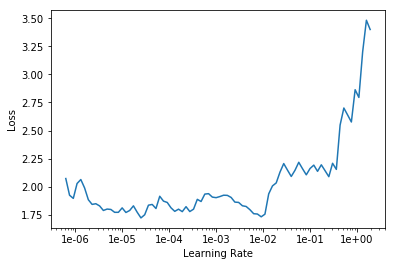

In [105]:
learn.recorder.plot()

In [142]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy


RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

Maybe use `loss(reduction="sum")` and average before `real_step()`

### MNIST batch size = 32, no accumulation

`effective batch size = 32`

In [123]:
import torchvision

In [124]:
# seed everything for reproducibility
seed_everything(42)

In [82]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path, bs=32)

In [83]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)

In [84]:
learn.loss_func = CrossEntropyFlat(reduction='mean')

In [12]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy
1,0.141535,0.079934,0.972031


### MNIST batch size=4, accumulate every n_step=8, Default

`effective batch size = 32 (bs x n_step)`

In [99]:
# seed everything for reproducibility
seed_everything(42)
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path, bs=2)
# freeze_to(-1) except for BN layers
learn = create_cnn(data, models.vgg16_bn, metrics=accuracy,
                   callback_fns=[partial(AccumulateStepper, n_step=16)])

In [102]:
learn.loss_func = CrossEntropyFlat(reduction='sum')

In [103]:
m = learn.model

In [104]:
for i, _ in enumerate(m[0][0].children()):
    if isinstance(m[0][0][i], bn_types):
        l = m[0][0][i]
        m[0][0][i] = AccumulateBatchNorm(l.__class__, l.num_features).cuda()

for i, _ in enumerate(m[1].children()):
    if isinstance(m[1][i], bn_types):
        l = m[1][i]
        m[1][i] = AccumulateBatchNorm(l.__class__, l.num_features).cuda()

In [105]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): AccumulateBatchNorm(
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): AccumulateBatchNorm(
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): AccumulateBatchNorm(
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): AccumulateBatchNorm(
        (bn): BatchNorm2d(128, eps=1e-05

In [106]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy


RuntimeError: the derivative for 'running_mean' is not implemented

### MNIST batch size=4, accumulate every n_step=8, BNFreeze

`effective batch size = 32 (bs x n_step)`

In [86]:
from fastai.train import BnFreeze

In [87]:
class BnFreeze(LearnerCallback):
    "Freeze moving average statistics in all non-trainable batchnorm layers."
    def on_train_begin(self, **kwargs:Any)->None:
        "Put bn layers in eval mode just after `model.train()`."
        set_bn_eval(self.learn.model)

In [88]:
# seed everything for reproducibility
seed_everything(42)

In [89]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path, bs=2)

In [90]:
# freeze_to(-1) including BN layers
learn = create_cnn(data, models.resnet18, metrics=accuracy,
                   callback_fns=[partial(AccumulateStepper, n_step=16), BnFreeze])

In [101]:
# freeze bn layers
for g in learn.layer_groups[:-1]:
    for l in g:
        if isinstance(l, bn_types): requires_grad(l, False)

In [103]:
find_active_bn(learn.model)

BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [104]:
learn.loss_func = CrossEntropyFlat(reduction='sum')

In [105]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy
1,1.140334,2.693619,0.601570


### MNIST batch size=4, accumulate every n_step=8, BNFreeze + More momentum

`effective batch size = 32 (bs x n_step)`

In [122]:
from fastai.train import BnFreeze

In [123]:
class BnFreeze(LearnerCallback):
    "Freeze moving average statistics in all non-trainable batchnorm layers."
    def on_train_begin(self, **kwargs:Any)->None:
        "Put bn layers in eval mode just after `model.train()`."
        set_bn_eval(self.learn.model)

In [124]:
# seed everything for reproducibility
seed_everything(42)

In [125]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path, bs=2)

In [126]:
# freeze_to(-1) including BN layers
learn = create_cnn(data, models.resnet18, metrics=accuracy,
                   callback_fns=[partial(AccumulateStepper, n_step=16), BnFreeze])

In [127]:
# # freeze bn layers
# for g in learn.layer_groups[:-1]:
#     for l in g:
#         if isinstance(l, bn_types): requires_grad(l, False)
for g in learn.layer_groups:
    for l in g:
        if isinstance(l, bn_types): l.momentum = 0.9

In [128]:
find_active_bn(learn.model)

BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
BatchNorm2d(256, eps=1e-05, momen

In [129]:
learn.loss_func = CrossEntropyFlat(reduction='sum')

In [130]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy
1,1.153869,411.230682,0.479392


### MNIST batch size=4, accumulate every n_step=8, BNFreeze + Custom Running

`effective batch size = 32 (bs x n_step)`

In [104]:
# seed everything for reproducibility
seed_everything(42)

In [105]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path, bs=2)

In [112]:
learn = create_cnn(data, models.resnet18, metrics=accuracy,
                   callback_fns=[partial(AccumulateStepper, n_step=16)])

In [113]:
learn.loss_func = CrossEntropyFlat(reduction='sum')

In [114]:
learn.fit(4)

epoch,train_loss,valid_loss,accuracy
1,1.543319,1.134782,0.743867
2,1.379197,1.387173,0.564769
3,1.277315,1.233230,0.696762
4,1.208992,1.130871,0.759078


### BatchNorm

In [54]:
seed_everything(42)

In [55]:
x = torch.randn((2, 5));x

tensor([[ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229],
        [-0.1863,  2.2082, -0.6380,  0.4617,  0.2674]])

In [56]:
bn = nn.BatchNorm1d(5)

In [57]:
mom = bn.momentum, 
mean = bn.running_mean
var = bn.running_var
w = bn.weight
b = bn.bias
eps = bn.eps

mean, var, w, b, eps

(tensor([0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1.]),
 Parameter containing:
 tensor([0.2696, 0.4414, 0.2969, 0.8317, 0.1053], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True),
 1e-05)

In [68]:
bn(x)

tensor([[ 0.2696, -0.4414,  0.2969, -0.8314, -0.1053],
        [-0.2696,  0.4414, -0.2969,  0.8314,  0.1053]],
       grad_fn=<NativeBatchNormBackward>)

In [69]:
mom = bn.momentum, 
mean = bn.running_mean
var = bn.running_var
w = bn.weight
b = bn.bias
eps = bn.eps

mean, var, w, b, eps

(tensor([ 0.0352,  0.5475, -0.0945,  0.1621, -0.2004]),
 tensor([0.5955, 1.5444, 0.7098, 0.5440, 0.9842]),
 Parameter containing:
 tensor([0.2696, 0.4414, 0.2969, 0.8317, 0.1053], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True),
 1e-05)

In [9]:
model = learn.model

In [19]:
model[0][:3]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)

In [13]:
bn = model[0][1]

In [22]:
bn.momentum, bn.running_mean, bn.running_var, bn.weight, bn.bias, bn.eps

(0.1, tensor([ 2.7681e-03, -2.5769e-02,  2.1254e-07, -8.4605e-02,  2.1121e-08,
          4.9691e-04, -2.2408e-02, -1.1582e-07, -4.8239e-03,  2.7507e-07,
          3.9582e-02,  3.1994e-02, -3.7490e-02, -1.3716e-06,  6.6002e-03,
          4.3782e-03,  6.4797e-02,  1.1176e-01,  3.6002e-02, -7.5075e-02,
         -3.8240e-02,  8.4358e-02, -5.2287e-02, -1.1799e-02,  1.3019e-03,
          3.2172e-02, -1.7784e-02, -9.1009e-02,  1.1319e-01, -4.1632e-02,
          8.7302e-03,  2.9693e-02, -7.0502e-02, -3.4847e-03,  1.0977e-01,
         -1.7341e-03, -5.9423e-08,  2.9330e-02, -7.8553e-09,  6.7320e-03,
         -3.7100e-03,  1.6028e-02, -2.7883e-02,  2.6593e-02,  2.8475e-02,
         -1.2735e-01,  4.4617e-02,  2.6329e-02,  2.1454e-08, -1.7045e-02,
         -3.5617e-03, -4.5841e-02,  6.3876e-02,  1.5220e-02, -3.8511e-02,
         -1.6428e-02, -1.6569e-02,  5.6057e-02, -8.0306e-02, -2.6646e-03,
         -4.1718e-02,  1.2611e-01, -4.9237e-02, -1.3261e-02], device='cuda:0'), tensor([1.0169e+00, 3.7167e

In [ ]:
class MyBatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True):
        super(MyBatchNorm, self).__init__()
        self.bn = nn.BatchNorm1d(num_features,
                                 eps=eps,
                                 momentum=momentum,
                                 affine=affine)

    def forward(self, x):        
        x = self.bn(x)
        mu = self.bn.running_mean
        var = self.bn.running_var
        gamma = self.bn.weight
        beta = self.bn.bias
        eps = self.bn.eps    
        k = gamma.data / torch.sqrt(var + eps)
        x.data = k * x.data + beta.data
        return x

mybn = MyBatchNorm(10)
x = Variable(torch.randn(16, 10))
x_ = mybn(x)